### NMR. Fitting Yosida function.

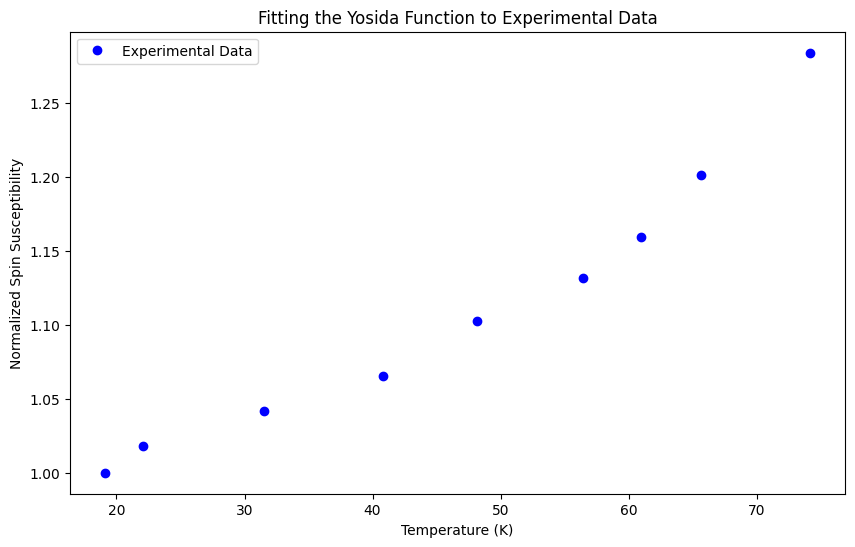

Fitted Δ0: 2.3084451280000003e-21 J
BCS theory Δ0: 1.8467561024e-21 J
Ratio (Fitted Δ0 / BCS Δ0): 1.25


In [20]:
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Constants
gamma_63Cu = 7.11e7  # Hz/T
mu_N = 1.12e-26  # J/T
A = 10e6  # Hz
T_c = 76  # K
k_B = 1.380649e-23  # Boltzmann constant in J/K

# Load the data
file_path = 'Knight Shift.xlsx'
data = pd.read_excel(file_path)

# Calculate Spin Susceptibility
data['Spin Susceptibility'] = (data['Knight Shift'] * gamma_63Cu * mu_N) / A

# Select data below Tc
data_below_Tc = data[data['Temperature (K)'] < T_c].copy()

# Normalize the Spin Susceptibility
lowest_temp_chi = data_below_Tc['Spin Susceptibility'].iloc[0]
data_below_Tc['Normalized Spin Susceptibility'] = data_below_Tc['Spin Susceptibility'] / lowest_temp_chi

# Define Yosida Function 
def yosida_function(T, delta_0):
    def integrand(E, T, delta_0):
        delta_T = delta_0
        if E <= delta_T:
            return 0
        x = E / (2 * k_B * T)
        if x > 500:  # To avoid overflow in cosh
            return 0
        cosh_x = np.cosh(x)
        return E / (np.sqrt(E**2 - delta_T**2) * cosh_x**2)
    
    integral_values = []
    for T_i in T:
        integral, error = quad(integrand, delta_0, 500 * k_B * T_i, args=(T_i, delta_0))
        integral_values.append(integral)
    return np.array(integral_values)

# Fit the data to the Yosida function
T_data = data_below_Tc['Temperature (K)'].values
chi_data = data_below_Tc['Normalized Spin Susceptibility'].values

# Filter out the temperatures close to Tc 
filtered_indices = T_data < T_c / 2
T_data_filtered = T_data[filtered_indices]
chi_data_filtered = chi_data[filtered_indices]

# Initial guess 
delta_0_initial = 1.76 * k_B * T_c

# Relaistic bounds to avoid overfitting
popt, pcov = curve_fit(yosida_function, T_data_filtered, chi_data_filtered, p0=[delta_0_initial], bounds=(delta_0_initial / 2, delta_0_initial * 2))
delta_0_fit = popt[0]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(T_data, chi_data, 'bo', label='Experimental Data')
plt.xlabel('Temperature (K)')
plt.ylabel('Normalized Spin Susceptibility')
plt.legend()
plt.title('Fitting the Yosida Function to Experimental Data')
plt.show()

# Display the fitted delta_0 and comparison to BCS theory
print(f"Fitted Δ0: {delta_0_fit} J")
print(f"BCS theory Δ0: {delta_0_initial} J")
print(f"Ratio (Fitted Δ0 / BCS Δ0): {delta_0_fit / delta_0_initial}")
